In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import json
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
os.chdir('../')
print(os.getcwd())

c:\Users\pehbo\projects\algo


In [4]:
# Function to create input-output sequence for the LSTM model
def create_sequence(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)




In [5]:
# Replace with your own API key and secret
with open('secrets/secrets.json') as f:
    secrets = json.load(f)
API_KEY = secrets['KEY']
API_SECRET = secrets['SECRET']
BASE_URL = 'https://paper-api.alpaca.markets'  # For paper trading, use the paper trading URL

# Set up the Alpaca API client
api = tradeapi.REST(API_KEY, API_SECRET, base_url=BASE_URL, api_version='v2')

In [20]:
symbol = 'AAPL'
start_date = '2010-01-01'
end_date = '2023-03-25'
timeframe = '1D'

historical_data = api.get_bars(symbol, tradeapi.rest.TimeFrame.Day, start=start_date, end=end_date).df

In [21]:
# Preprocess the data
close_prices = historical_data['close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

# Create the input-output sequences for the LSTM model
window_size = 60
X, y = create_sequence(scaled_close_prices, window_size)

# Split the data into training (80%) and testing (20%) sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



In [22]:
# Build the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, 1), return_sequences=True),
    LSTM(units=50, activation='relu', return_sequences=True),
    LSTM(units=50, activation='relu'),
    Dense(units=1)
])

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
train_preds = scaler.inverse_transform(model.predict(X_train))
test_preds = scaler.inverse_transform(model.predict(X_test))



Epoch 1/50
45/45 [==============================] - 10s 118ms/step - loss: 0.0158 - val_loss: 0.0011
Epoch 2/50
45/45 [==============================] - 5s 115ms/step - loss: 0.0082 - val_loss: 0.0013
Epoch 3/50
45/45 [==============================] - 5s 121ms/step - loss: 0.0047 - val_loss: 3.5921e-04
Epoch 4/50
45/45 [==============================] - 5s 119ms/step - loss: 0.0039 - val_loss: 7.1290e-04
Epoch 5/50
45/45 [==============================] - 5s 117ms/step - loss: 0.0032 - val_loss: 3.5054e-04
Epoch 6/50
45/45 [==============================] - 5s 116ms/step - loss: 0.0031 - val_loss: 5.0240e-04
Epoch 7/50
45/45 [==============================] - 5s 115ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 8/50
45/45 [==============================] - 5s 117ms/step - loss: 0.0027 - val_loss: 3.1455e-04
Epoch 9/50
45/45 [==============================] - 5s 113ms/step - loss: 0.0019 - val_loss: 3.5507e-04
Epoch 10/50
45/45 [==============================] - 5s 118ms/step - loss: 

<module 'matplotlib.pyplot' from 'c:\\Users\\pehbo\\anaconda3\\envs\\algo\\lib\\site-packages\\matplotlib\\pyplot.py'>

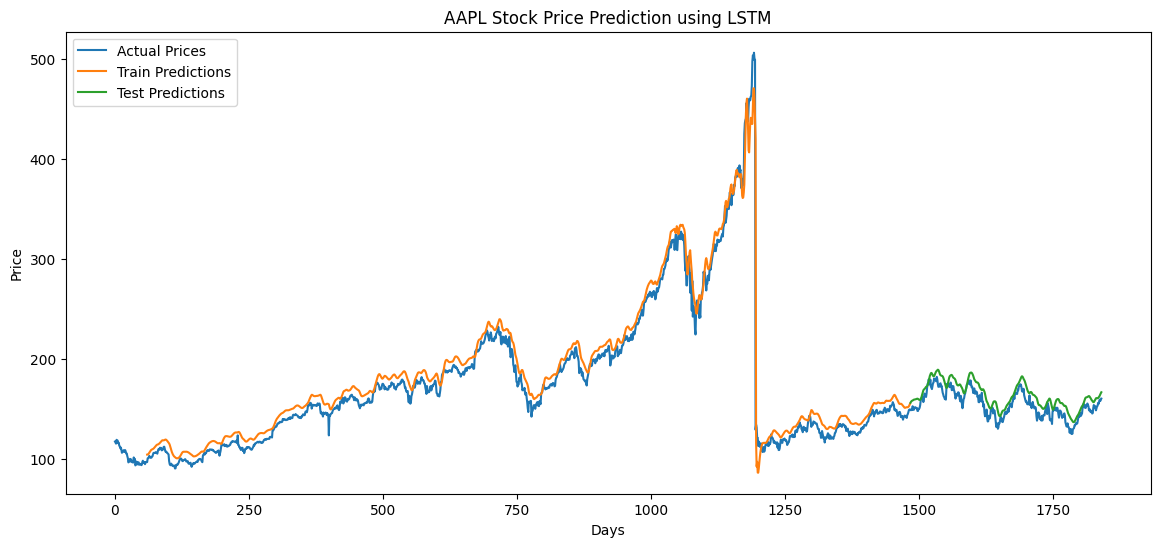

In [23]:
# Plot the predictions
plt.figure(figsize=(14, 6))
plt.plot(close_prices, label='Actual Prices')
plt.plot(range(window_size, window_size + len(train_preds)), train_preds, label='Train Predictions')
plt.plot(range(window_size + len(train_preds), len(close_prices)), test_preds, label='Test Predictions')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f'{symbol} Stock Price Prediction using LSTM')
plt.legend(loc='upper left')
plt

In [24]:
dates = historical_data.index

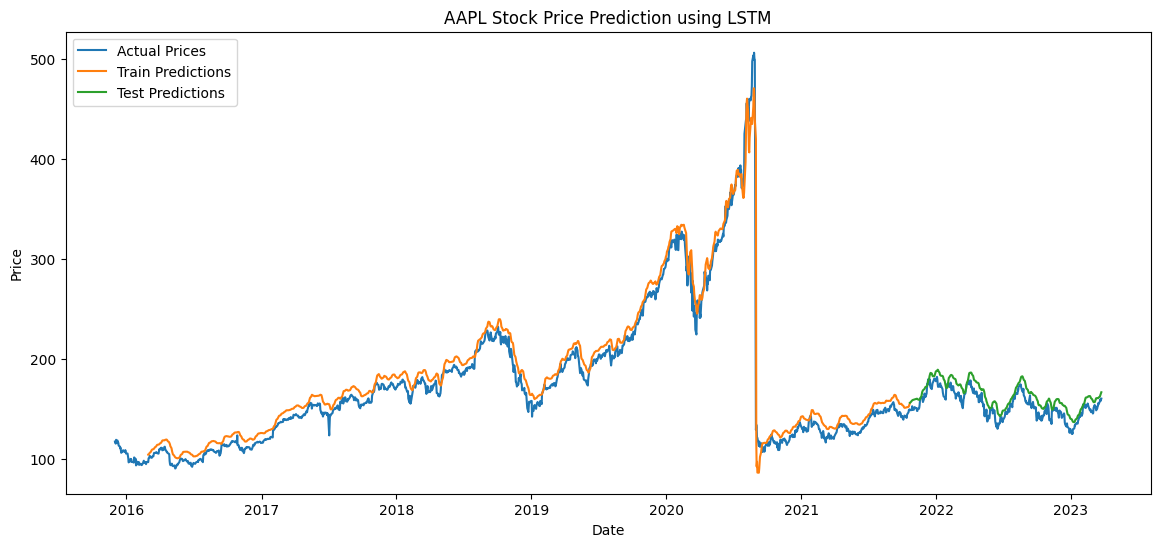

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(dates, close_prices, label='Actual Prices')
plt.plot(dates[window_size:window_size + len(train_preds)], train_preds, label='Train Predictions')
plt.plot(dates[window_size + len(train_preds):], test_preds, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{symbol} Stock Price Prediction using LSTM')
plt.legend(loc='upper left')
plt.show()